In [3]:
import numpy as np
import scipy.ndimage
import skimage.transform
import skimage.registration
import os
import pandas
import csv

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['image.cmap'] = 'inferno'
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['image.origin'] = 'lower'
plt.style.use('dark_background')

import astropy.units as u
import astropy.constants as c
import astropy.io.fits as fits
import astropy.table
import photutils

### File paths

In [4]:
data_dir = os.path.relpath("../../Data/official2019/SS/SS DATA/")

cal_dir = os.path.relpath("../../Data/official2019/SS/SS CAL/")

In [5]:
ss_coadd_fname = os.path.join(
        data_dir,
        'starshade_run_dc2_jitter_perturbedSS_solar_glint_with_extragalactic_background_and_5exozodi_129600sec_with_emccd.fits')

jitter_glint_cal_fname = os.path.join(
        cal_dir,
        'starshade_run_dc2_jitter_solar_glint_43200sec_with_emccd.fits')

psf_model_fname = os.path.join(
         cal_dir,
        'starshade_run_dc2_psf_21.08mas.fits')

### Parameters

In [6]:
epoch_ind = 4 # first epoch = 0

det_qe = 0.75 * u.electron / u.photon # effective QE of detector
pc_loss = 0.8 # photon counting coincidence losses
tot_inttime = 2 * 66000 * u.second
print(tot_inttime.to(u.hour))

star_countrate = 1.9238E8 * u.photon / u.second

pix_scale = 21.0804 * u.mas

36.666666666666664 h


### Set science coadd

In [7]:
ss_coadd_cube = fits.getdata(ss_coadd_fname)
print(ss_coadd_cube.shape)
ss_coadd = ss_coadd_cube[epoch_ind - 4] # First starshade epoch is the 5th overall

(2, 97, 97)


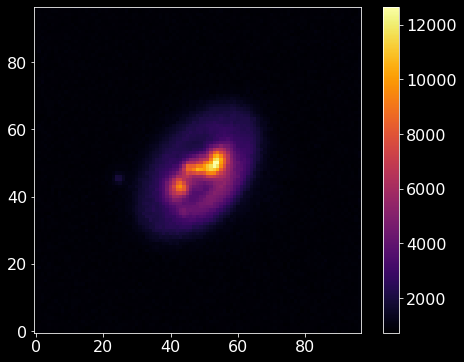

In [8]:
plt.figure(figsize=(8,6))
plt.imshow(ss_coadd)
plt.colorbar()

### Choose source position

In [9]:
img_width = ss_coadd.shape[0]
phot_box_width = 3
plot_box_width = 7

XXs, YYs = np.meshgrid(np.arange(img_width), np.arange(img_width))

lowerleft_quad_mask = ((XXs < img_width // 2) & (YYs < img_width // 2 - 9))

peak_row = np.nanargmax(np.ravel(ss_coadd * lowerleft_quad_mask)) // img_width
peak_col = np.nanargmax(np.ravel(ss_coadd * lowerleft_quad_mask)) % img_width
peak_val = ss_coadd[peak_row, peak_col]

print("Peak col = {:d}, peak row = {:d}".format(peak_col, peak_row))
print("Peak value = {:.1f}".format(peak_val))

Peak col = 44, peak row = 36
Peak value = 4582.0


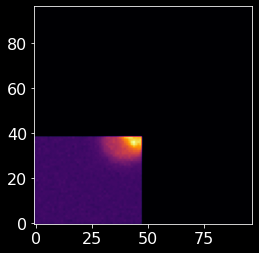

In [10]:
plt.imshow(lowerleft_quad_mask * ss_coadd)

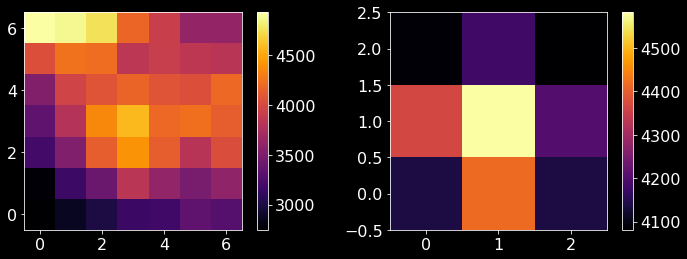

In [11]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plot_box_width = 7
plt.imshow(ss_coadd[peak_row - plot_box_width//2 : peak_row + plot_box_width // 2 + 1,
                    peak_col - plot_box_width//2 : peak_col + plot_box_width // 2 + 1])
plt.colorbar()

plt.subplot(122)
plt.imshow(ss_coadd[peak_row - phot_box_width//2 : peak_row + phot_box_width // 2 + 1,
                    peak_col - phot_box_width//2 : peak_col + phot_box_width // 2 + 1])
plt.colorbar()

In [12]:
phot_box_sum = np.sum(
        ss_coadd[peak_row - phot_box_width // 2 : peak_row + phot_box_width // 2 + 1,
                 peak_col - phot_box_width // 2 : peak_col + phot_box_width // 2 + 1]
        * u.electron)

print(phot_box_sum)

38190.0 electron


### Choose the background region and sum the planet flux

In [13]:
bg_copy = ss_coadd.copy()

bg_copy[peak_row - phot_box_width//2 : peak_row + phot_box_width // 2 + 1,
        peak_col - phot_box_width//2 : peak_col + phot_box_width // 2 + 1] = np.nan

bg_samp_col = peak_col
bg_samp_row = peak_row
bg_xbeg = bg_samp_col - 3
bg_xend = bg_samp_col + 3
bg_ybeg = bg_samp_row - 2
bg_yend = bg_samp_row + 2
bg_box_npix = ((bg_xend - bg_xbeg + 1) * (bg_yend - bg_ybeg + 1) 
               - phot_box_width * phot_box_width)

bg_est = np.nanmedian(bg_copy[bg_ybeg : bg_yend + 1, bg_xbeg : bg_xend + 1]) * u.electron
bg_std = np.nanstd(bg_copy[bg_ybeg : bg_yend + 1, bg_xbeg : bg_xend + 1]) * u.electron
    
peak_to_bg_SNR = (peak_val * u.electron - bg_est) / bg_std

phot_box_sum_bgsub = phot_box_sum - bg_est * (phot_box_width * phot_box_width)

print("Number of pixels in B.g. sample = {:d}".format(bg_box_npix))
print("B.g. estimate = {:.3f}".format(bg_est))
print("B.g. std dev = {:.3f}".format(bg_std))
print("B.g.-subtracted aperture sum = {:.3f}".format(phot_box_sum_bgsub))
print("Peak-to-B.g. SNR estimate = {:.1f}".format(peak_to_bg_SNR))

Number of pixels in B.g. sample = 26
B.g. estimate = 3832.500 electron
B.g. std dev = 369.481 electron
B.g.-subtracted aperture sum = 3697.500 electron
Peak-to-B.g. SNR estimate = 2.0


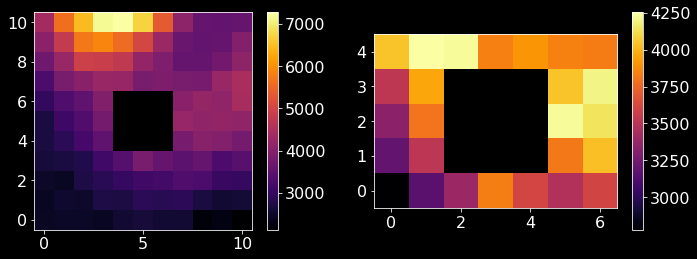

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plot_box_width = 10
plt.imshow(bg_copy[bg_samp_row - plot_box_width//2 : bg_samp_row + plot_box_width // 2 + 1,
                   bg_samp_col - plot_box_width//2 : bg_samp_col + plot_box_width // 2 + 1])
plt.colorbar()

plt.subplot(122)
plt.imshow(bg_copy[bg_ybeg : bg_yend + 1, bg_xbeg : bg_xend + 1])
plt.colorbar()

#### Lower left corner of image (local zodi?)

In [15]:
print(np.median(ss_coadd[0:20, 0:20]))
print(np.std(ss_coadd[0:20, 0:20]))

874.5
49.227932


### Calibrate flux ratio

16 16
Photometric box energy fraction of PSF = 0.6453
Peak col = 16, peak row = 16
Unocculted star count rate in 3 x 3 box = 1.241E+08 ph / s


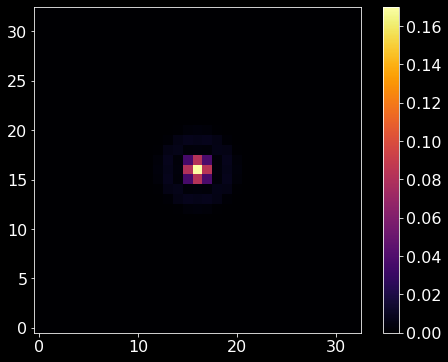

In [16]:
psf_model = fits.getdata(psf_model_fname)
psf_model_img_width = psf_model.shape[0]

psf_model_peak_row = np.nanargmax(np.ravel(psf_model)) // psf_model_img_width
psf_model_peak_col = np.nanargmax(np.ravel(psf_model)) % psf_model_img_width
print(psf_model_peak_col, psf_model_peak_row)


phot_box_energy_fraction = np.sum(
        psf_model[psf_model_peak_row - phot_box_width//2 : psf_model_peak_row + phot_box_width // 2 + 1,
                  psf_model_peak_col - phot_box_width//2 : psf_model_peak_col + phot_box_width // 2 + 1])

star_phot_box_sum = star_countrate * phot_box_energy_fraction

print("Photometric box energy fraction of PSF = {:.4f}".format(phot_box_energy_fraction))
print("Peak col = {:d}, peak row = {:d}".format(psf_model_peak_col, psf_model_peak_row))
print("Unocculted star count rate in {:d} x {:d} box = {:.3E}".format(phot_box_width, phot_box_width, star_phot_box_sum))

plt.figure(figsize=(8, 6))
plt.imshow(psf_model)
plt.colorbar()

In [17]:
planet_phot_box_sum = (phot_box_sum_bgsub / (det_qe * pc_loss)) / tot_inttime
print("Planet PSF photon count rate in {:d} x {:d} box = {:.2E}".format(
      phot_box_width, phot_box_width, planet_phot_box_sum))

planet_flux_ratio = planet_phot_box_sum / star_phot_box_sum
print("Measured planet flux ratio = {:.3E}".format(planet_flux_ratio))

Planet PSF photon count rate in 3 x 3 box = 4.67E-02 ph / s
Measured planet flux ratio = 3.761E-10


### Astrometry

In [18]:
src_y_offset = (peak_row - img_width // 2) * pix_scale
src_x_offset = (peak_col - img_width // 2) * pix_scale

In [19]:
src_y_offset.to(u.mas), src_x_offset.to(u.mas)

(<Quantity -252.9648 mas>, <Quantity -84.3216 mas>)

In [20]:
pix_ld = 0.5
sigma = (1 / pix_ld) / peak_to_bg_SNR * pix_scale
print(sigma)

20.783991906576226 mas
